# Cleaning and Exploring the Datasets

**Star Trek Series**

| Series | Seasons | Episodes | Originally released | In Dataset |
| :----: | :----: | :----: | :----: | :----: |
| The Original Series | 3 | 79 | September 8, 1966 – June 3, 1969 | yes |
| The Animated Series | 2 | 22 | September 8, 1973 – October 12, 1974 | yes |
| The Next Generation | 7 | 178 | September 28, 1987 – May 23, 1994 | yes |
| Deep Space Nine | 7 | 176 | January 4, 1993 – May 31, 1999 | yes |
| Voyager | 7 | 172 | January 16, 1995 – May 23, 2001 | yes |
| Enterprise | 4 | 98 | September 26, 2001 – May 13, 2005 | yes |
| Discovery | 3 | 42 | September 24, 2017 – present | only 1st season |
| Short Treks | 2 | 10 | October 4, 2018 – January 9, 2020 | no |
| Picard | 1 | 10 | January 23, 2020 – present | no |
| Lower Decks | 1 | 10 | August 6, 2020 – present | no |

Source: [Wikipedia:StarTrek#Television](https://en.wikipedia.org/wiki/Star_Trek#Television)

## List of Episodes with Transcripts

Source: [www.chakoteya.net | The Star Trek Transcripts](http://www.chakoteya.net/StarTrek/index.html)


## Data structure:

| id | airdate | series | production_number | episode_title | script |
| :----: | :----: | :----: | :----: | :----: | :----: |
| id | airdate | series | production_number | episode_title | script |
| id | airdate | series | production_number | episode_title | script |

**Resources**

- [stackoverflow - Check if string has date, any format](https://stackoverflow.com/questions/25341945/check-if-string-has-date-any-format)

In [89]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("darkgrid")
sns.set_palette("Set2")

import nltk
import spacy
import contractions
import unicodedata
from dateutil.parser import parse

In [10]:
# load Datasets
metadata_df = pd.read_csv('../data/raw_data/st_metadata.csv')
summaries_df = pd.read_csv('../data/raw_data/st_summaries.csv')
transcripts_df = pd.read_csv('../data/raw_data/st_transcripts.csv')

# Metadata

In [12]:
metadata_df.head()

,episode,title,abbr,stardate,original_airdate,production_number
0,0x01,The Cage,TOS,Unknown,1988-10-04,6149-01
1,1x01,Where No Man Has Gone Before,TOS,1312.4 - 1313.8,1966-09-22,6149-02
2,1x02,The Corbomite Maneuver,TOS,1512.2 - 1514.1,1966-11-10,6149-03
3,1x03,Mudd's Women,TOS,1329.8 - 1330.1,1966-10-13,6149-04
4,1x04,The Enemy Within,TOS,1672.1 - 1673.1,1966-10-06,6149-05


In [11]:
metadata_df.shape

(791, 6)

In [21]:
metadata_df.dtypes

episode              object
title                object
abbr                 object
stardate             object
original_airdate     object
production_number    object
dtype: object

In [23]:
# Check if original_airdate column contains strings that can be converted to date
def is_date(string, fuzzy=False):
    """
    Return whether the string can be interpreted as a date.

    :param string: str, string to check for date
    :param fuzzy: bool, ignore unknown tokens in string if True
    """
    try: 
        parse(string, fuzzy=fuzzy)
        return True

    except ValueError:
        return False

In [24]:
date_bool = metadata_df.apply(lambda row : is_date(row['original_airdate']), axis = 1)

In [28]:
metadata_df.iloc[metadata_df[date_bool == False].index]

,episode,title,abbr,stardate,original_airdate,production_number
725,Chapter Two,Chapter Two,DIS,Chapter Two,Chapter Two,Chapter Two


In [29]:
metadata_df = metadata_df.drop(metadata_df[date_bool == False].index)

In [32]:
metadata_df['original_airdate'] = pd.to_datetime(metadata_df['original_airdate'])

In [35]:
print("Number of series in Dataset: ", metadata_df['abbr'].nunique())
print("Number of unique episode titles in Dataset: ", metadata_df['title'].nunique())
print("Number of airdates in Dataset: ", metadata_df['original_airdate'].nunique())

Number of series in Dataset:  9
Number of unique episode titles in Dataset:  790
Number of airdates in Dataset:  734


In [61]:
#metadata_df.sort_values(by = ['abbr', 'original_airdate'], ascending=[True, True])

In [62]:
#metadata_df[metadata_df['original_airdate'].duplicated(keep=False)]

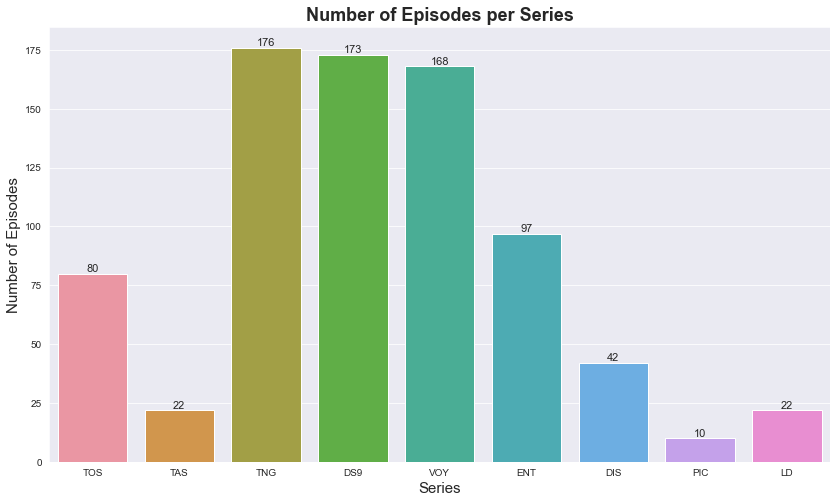

In [95]:
plt.figure(figsize=(14,8))
ax = sns.countplot(data=metadata_df, x = 'abbr',  
            order=['TOS', 'TAS', 'TNG', 'DS9', 'VOY', 'ENT', 'DIS', 'PIC', 'LD'])

ax.set_title('Number of Episodes per Series',fontsize = 18, fontweight='bold' )
ax.set_xlabel('Series', fontsize = 15)
ax.set_ylabel('Number of Episodes', fontsize = 15)

for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()
             + 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)

plt.show()

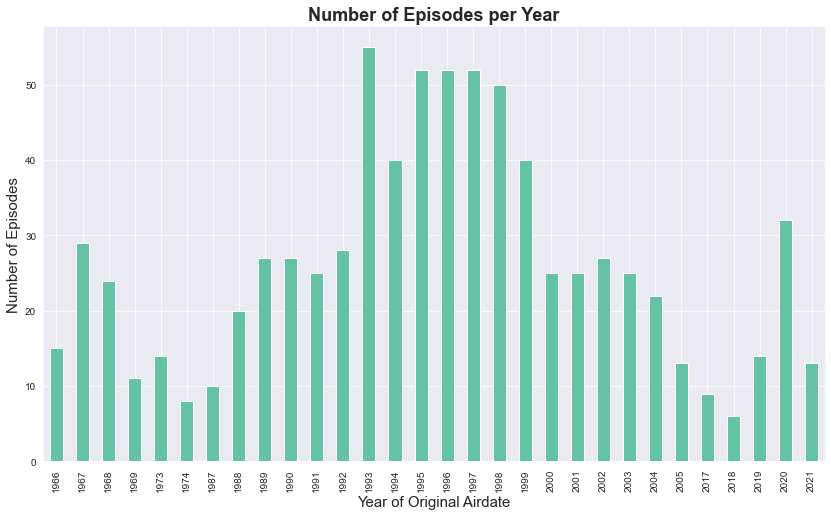

In [98]:
ax = metadata_df.groupby(metadata_df["original_airdate"].dt.year)['episode'].count().plot(kind="bar", \
                                                                                           figsize=(14,8))

ax.set_title('Number of Episodes per Year',fontsize = 18, fontweight='bold' )
ax.set_xlabel('Year of Original Airdate', fontsize = 15)
ax.set_ylabel('Number of Episodes', fontsize = 15)

plt.show()

# Summaries

In [17]:
summaries_df.head()

,episode_abbr,episode_titles,episode_urls,summary_text_clean
0,TOS,The Cage,https://memory-alpha.fandom.com/wiki/The_Cage_...,"Captain Pike on the bridge The year is 2254, ..."
1,TOS,Where No Man Has Gone Before,https://memory-alpha.fandom.com/wiki/Where_No_...,"""I'll have you checkmated your next move…"" ""C..."
2,TOS,The Corbomite Maneuver,https://memory-alpha.fandom.com/wiki/The_Corbo...,The mysterious object The USS Enterprise is i...
3,TOS,Mudd's Women,https://memory-alpha.fandom.com/wiki/Mudd%27s_...,The USS Enterprise chases an unregistered sta...
4,TOS,The Enemy Within,https://memory-alpha.fandom.com/wiki/The_Enemy...,"During a survey of Alfa 177, geological techn..."


In [13]:
summaries_df.shape

(778, 4)

In [63]:
summaries_df.dtypes

episode_abbr          object
episode_titles        object
episode_urls          object
summary_text_clean    object
dtype: object

In [18]:
print("Number of series in Dataset: ", summaries_df['episode_abbr'].nunique())
print("Number of unique episode titles in Dataset: ", summaries_df['episode_titles'].nunique())
print("Number of unique episode scripts in Dataset: ", summaries_df['summary_text_clean'].nunique())

Number of series in Dataset:  9
Number of unique episode titles in Dataset:  778
Number of unique episode scripts in Dataset:  778


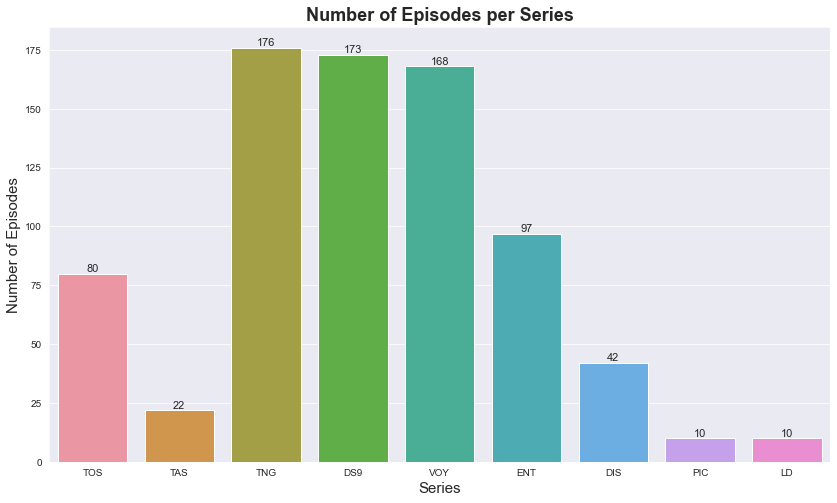

In [96]:
plt.figure(figsize=(14,8))
ax = sns.countplot(data=summaries_df, x = 'episode_abbr',  
            order=['TOS', 'TAS', 'TNG', 'DS9', 'VOY', 'ENT', 'DIS', 'PIC', 'LD'])

ax.set_title('Number of Episodes per Series',fontsize = 18, fontweight='bold' )
ax.set_xlabel('Series', fontsize = 15)
ax.set_ylabel('Number of Episodes', fontsize = 15)

for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height() 
             + 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)

plt.show()

In [69]:
summaries_df

,episode_abbr,episode_titles,episode_urls,summary_text_clean
0,TOS,The Cage,https://memory-alpha.fandom.com/wiki/The_Cage_...,"Captain Pike on the bridge The year is 2254, ..."
1,TOS,Where No Man Has Gone Before,https://memory-alpha.fandom.com/wiki/Where_No_...,"""I'll have you checkmated your next move…"" ""C..."
2,TOS,The Corbomite Maneuver,https://memory-alpha.fandom.com/wiki/The_Corbo...,The mysterious object The USS Enterprise is i...
3,TOS,Mudd's Women,https://memory-alpha.fandom.com/wiki/Mudd%27s_...,The USS Enterprise chases an unregistered sta...
4,TOS,The Enemy Within,https://memory-alpha.fandom.com/wiki/The_Enemy...,"During a survey of Alfa 177, geological techn..."
...,...,...,...,...
773,LD,Terminal Provocations,https://memory-alpha.fandom.com/wiki/Terminal_...,"In the lower decks crew quarters, Ensign Brad..."
774,LD,Much Ado About Boimler,https://memory-alpha.fandom.com/wiki/Much_Ado_...,"Ensigns Brad Boimler, Beckett Mariner, and Sa..."
775,LD,Veritas,https://memory-alpha.fandom.com/wiki/Veritas_(...,"On K'Tuevon Prime, Ensigns Beckett Mariner, B..."
776,LD,Crisis Point,https://memory-alpha.fandom.com/wiki/Crisis_Po...,"On the surface of a planet, a huge statue of ..."


In [73]:
# Check if titles in Summaries are also in Metadata
#metadata_df.where(metadata_df['title']==summaries_df['episode_titles']).notna()
summaries_full = pd.merge(metadata_df, summaries_df, left_on='title', right_on='episode_titles')

In [74]:
summaries_full.shape

(778, 10)

In [76]:
# Check for missing data
summaries_full.isna().sum()

episode               0
title                 0
abbr                  0
stardate              0
original_airdate      0
production_number     0
episode_abbr          0
episode_titles        0
episode_urls          0
summary_text_clean    0
dtype: int64

In [77]:
summaries_full.head()

,episode,title,abbr,stardate,original_airdate,production_number,episode_abbr,episode_titles,episode_urls,summary_text_clean
0,0x01,The Cage,TOS,Unknown,1988-10-04,6149-01,TOS,The Cage,https://memory-alpha.fandom.com/wiki/The_Cage_...,"Captain Pike on the bridge The year is 2254, ..."
1,1x01,Where No Man Has Gone Before,TOS,1312.4 - 1313.8,1966-09-22,6149-02,TOS,Where No Man Has Gone Before,https://memory-alpha.fandom.com/wiki/Where_No_...,"""I'll have you checkmated your next move…"" ""C..."
2,1x02,The Corbomite Maneuver,TOS,1512.2 - 1514.1,1966-11-10,6149-03,TOS,The Corbomite Maneuver,https://memory-alpha.fandom.com/wiki/The_Corbo...,The mysterious object The USS Enterprise is i...
3,1x03,Mudd's Women,TOS,1329.8 - 1330.1,1966-10-13,6149-04,TOS,Mudd's Women,https://memory-alpha.fandom.com/wiki/Mudd%27s_...,The USS Enterprise chases an unregistered sta...
4,1x04,The Enemy Within,TOS,1672.1 - 1673.1,1966-10-06,6149-05,TOS,The Enemy Within,https://memory-alpha.fandom.com/wiki/The_Enemy...,"During a survey of Alfa 177, geological techn..."


In [79]:
# drop unnecessary columns
cols_to_drop = ['episode_abbr', 'episode_titles', 'episode_urls']

#st_metadata_df = 
summaries_full.drop(cols_to_drop, axis=1)

,episode,title,abbr,stardate,original_airdate,production_number,summary_text_clean
0,0x01,The Cage,TOS,Unknown,1988-10-04,6149-01,"Captain Pike on the bridge The year is 2254, ..."
1,1x01,Where No Man Has Gone Before,TOS,1312.4 - 1313.8,1966-09-22,6149-02,"""I'll have you checkmated your next move…"" ""C..."
2,1x02,The Corbomite Maneuver,TOS,1512.2 - 1514.1,1966-11-10,6149-03,The mysterious object The USS Enterprise is i...
3,1x03,Mudd's Women,TOS,1329.8 - 1330.1,1966-10-13,6149-04,The USS Enterprise chases an unregistered sta...
4,1x04,The Enemy Within,TOS,1672.1 - 1673.1,1966-10-06,6149-05,"During a survey of Alfa 177, geological techn..."
...,...,...,...,...,...,...,...
773,1x06,Terminal Provocations,LD,57663.9,2020-09-10,LD-1006,"In the lower decks crew quarters, Ensign Brad..."
774,1x07,Much Ado About Boimler,LD,57752.6,2020-09-17,LD-1007,"Ensigns Brad Boimler, Beckett Mariner, and Sa..."
775,1x08,Veritas,LD,Unknown,2020-09-24,LD-1008,"On K'Tuevon Prime, Ensigns Beckett Mariner, B..."
776,1x09,Crisis Point,LD,Unknown,2020-10-01,LD-1009,"On the surface of a planet, a huge statue of ..."


# Transcripts

In [19]:
transcripts_df.head()

,series,production_number,episode_title,script_link,transcript
0,StarTrek,1,The Cage,http://www.chakoteya.net/StarTrek/1.htm,\n\n\n\n\n\nThe Star Trek Transcripts - The Ca...
1,StarTrek,6,The Man Trap,http://www.chakoteya.net/StarTrek/6.htm,\n\n\n\n\n\nThe Star Trek Transcripts - The Ma...
2,StarTrek,8,Charlie X,http://www.chakoteya.net/StarTrek/8.htm,\n\n\n\n\n\nThe Star Trek Transcripts - Charli...
3,StarTrek,2,Where No Man Has Gone Before,http://www.chakoteya.net/StarTrek/2.htm,\n\n\n\n\n\nThe Star Trek Transcripts - Where ...
4,StarTrek,7,The Naked Time,http://www.chakoteya.net/StarTrek/7.htm,\n\n\n\n\n\nThe Star Trek Transcripts - The Na...


In [14]:
transcripts_df.shape

(727, 5)

In [20]:
print("Number of series in Dataset: ", transcripts_df['series'].nunique())
print("Number of unique episode titles in Dataset: ", transcripts_df['episode_title'].nunique())
print("Number of unique episode links in Dataset: ", transcripts_df['script_link'].nunique())
print("Number of unique episode scripts in Dataset: ", transcripts_df['transcript'].nunique())

Number of series in Dataset:  6
Number of unique episode titles in Dataset:  727
Number of unique episode links in Dataset:  727
Number of unique episode scripts in Dataset:  723


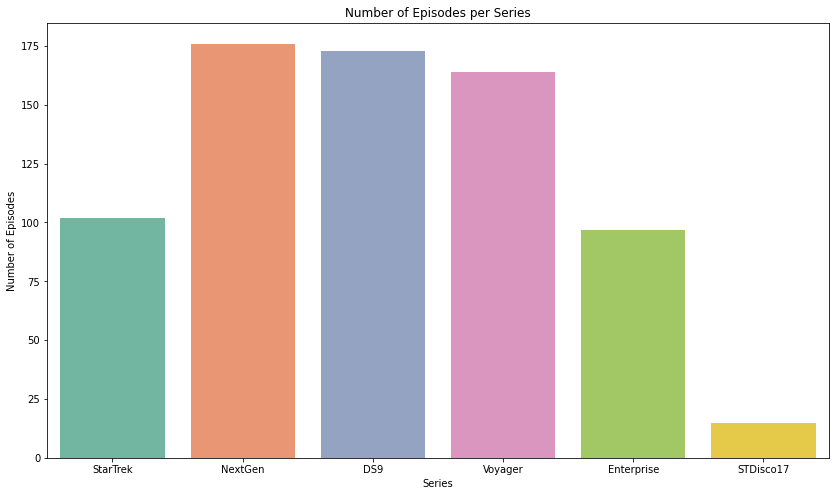

In [88]:
plt.figure(figsize=(14,8))
ax = sns.countplot(data=transcripts_df, x = 'series')  
            #order=['TOS', 'TAS', 'TNG', 'DS9', 'VOY', 'ENT', 'DIS', 'PIC', 'LD'])

plt.xlabel('Series')
plt.ylabel('Number of Episodes')
plt.title('Number of Episodes per Series')
plt.show()

In [ ]:
# Two part episodes have the same transcripts
episodes_df[episodes_df.duplicated(['transcript'])]

In [ ]:
# Create mapping from series names to abbreviations
series_names_chakoteya = []

series_abbrs = episodes_summaries_df['episode_abbr'].unique().tolist()
series_abbrs